In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def mix_beta(z):
    Z1, Z2 = z
    if np.random.rand() < 0.5:
        alpha, beta = 25 * Z1 + 1, 25 * (1 - Z1) + 1
    else:
        alpha, beta = 25 * (1 - Z2) + 1, 25 * Z2 + 1
    return alpha, beta

def mix_beta_full(z):
    Z1, Z2 = z
    alpha_1, beta_1 = 25 * Z1 + 1, 25 * (1 - Z1) + 1
    alpha_2, beta_2 = 25 * (1 - Z2) + 1, 25 * Z2 + 1
    return (alpha_1 / (alpha_1 + beta_1) + alpha_2 / (alpha_2 + beta_2)) / 2

def mix_beta_oracle(Z_new):
    results = []
    for z in Z_new:
        Z1, Z2 = z
        alpha_1, beta_1 = 25 * Z1 + 1, 25 * (1 - Z1) + 1
        alpha_2, beta_2 = 25 * (1 - Z2) + 1, 25 * Z2 + 1
        result = np.array([(alpha_1 + alpha_2) / 2, (beta_1 + beta_2) / 2])
        results.append(result)
    return np.array(results)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [4]:
# Define the Flexible Neural Network model
class FlexibleNN(nn.Module):
    def __init__(self, input_dim=22):
        super(FlexibleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, Z, summary_stat):
        x = torch.cat((Z, summary_stat.repeat(1, 10)), dim=1)  # Repeat the summary stat tuple 10 times
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Define the Beta-Bernoulli NN model
class BetaBernoulliNN(nn.Module):
    def __init__(self, input_dim=22):
        super(BetaBernoulliNN, self).__init__()
        self.alpha_mlp = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1),
            nn.ReLU()
        )
        self.beta_mlp = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1),
            nn.ReLU()
        )
        
        # Initialize bias terms to 1 to avoid starting with Beta parameters of value 0
        for layer in [self.alpha_mlp[-2], self.beta_mlp[-2]]:
            nn.init.constant_(layer.bias, 1.0)

    def forward(self, Z, summary_stat):
        x = torch.cat((Z, summary_stat.repeat(1, 10)), dim=1)  # Repeat the summary stat tuple 10 times
        alpha = self.alpha_mlp(x)
        beta = self.beta_mlp(x)
        return alpha / (alpha + beta)

In [5]:
# Load the model state dictionary
FlexibleNN_model = FlexibleNN()  # Initialize a new instance of the model
FlexibleNN_model.load_state_dict(torch.load("model/flexible_nn_model.pth", map_location=torch.device('cpu')))
FlexibleNN_model.eval()  # Set to evaluation mode for inference

FlexibleNN(
  (fc1): Linear(in_features=22, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [6]:
# Load the model state dictionary
BetaBernoulliNN_model = BetaBernoulliNN()  # Initialize a new instance of the model
BetaBernoulliNN_model.load_state_dict(torch.load("model/BetaBernoulli_nn_model.pth", map_location=torch.device('cpu')))
BetaBernoulliNN_model.eval()  # Set to evaluation mode for inference

BetaBernoulliNN(
  (alpha_mlp): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=1, bias=True)
    (5): ReLU()
  )
  (beta_mlp): Sequential(
    (0): Linear(in_features=22, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=1, bias=True)
    (5): ReLU()
  )
)

In [12]:
# Parameters
load_path = "data/Z_new.pt"

# Load the tensor from the specified file
Z_new = torch.load(load_path)
T_new = 500  # Number of time periods for outcomes per action in evaluation

optimal_z = np.argmax([mix_beta_full(z).item() for z in Z_new])

In [13]:
def posterior_sampling_via_autoregressive_generation(model, Z_new, T_new, optimal_z):
    """
    Implements Algorithm 2: Posterior Sampling via Autoregressive Generation (PS-AR)
    
    Args:
        model: Trained autoregressive model.
        Z_new: Attributes of new actions (Tensor of shape [num_actions_new, 2]).
        T_new: Number of time periods for outcomes.
        optimal_z: Index of the optimal action in Z_new.
    
    Returns:
        List of selected actions over T_new time periods and the cumulative regret path.
    """
    model.eval()  # Set the model to evaluation mode
    
    # Step 1: Initialize observed user indices list T_obs for each action
    T_obs = {a: [] for a in range(len(Z_new))}  # T_obs[a] will store observed indices for action a
    Y_obs = {a: [] for a in range(len(Z_new))}  # Y_obs[a] will store observed values for action a
    
    # To store selected actions over time periods
    selected_actions = []

    # Initialize cumulative rewards
    cumulative_reward_selected = 0.0
    cumulative_reward_optimal = 0.0

    # List to track cumulative regret at each time step
    regret_path = []

    # Step 2: Loop over each time period
    for t in tqdm(range(1, T_new + 1)):
        
        # Step 3: Loop over each action to generate hypothetical outcomes
        T_gen = {a: [] for a in range(len(Z_new))}  # T_gen[a] will store generated indices for action a
        Y_gen = {a: [] for a in range(len(Z_new))}  # Y_gen[a] will store generated values for action a

        for a in range(len(Z_new)):
            # Step 4: Loop to generate hypothetical outcomes for missing values
            unobserved_indices = [tau for tau in range(1, T_new + 1) if tau not in T_obs[a]]
            for tau in unobserved_indices:
                # Step 6: Generate hypothetical outcome for missing value using model
                Z_tensor = Z_new[a].unsqueeze(0)  # Shape: [1, 2]
                
                # Concatenate observed and generated outcomes to use as the input to the model
                Y_tot = Y_obs[a] + Y_gen[a]
                if len(Y_tot) == 0:
                    stat_1 = torch.zeros((1, 1), dtype=torch.float32)  # No previous observations
                else:
                    stat_1 = torch.tensor(Y_tot, dtype=torch.float32).mean().view(1, 1)

                stat_2 = torch.tensor([1 / (1 + len(Y_tot))], dtype=torch.float32).view(1, 1)
                summary_stat = torch.cat((stat_1, stat_2), dim=1)

                with torch.no_grad():
                    # Autoregressively sample hypothetical outcome for the missing value
                    Y_tau_hat = np.random.binomial(1, model(Z_tensor, summary_stat).item())
                    T_gen[a].append(tau)
                    Y_gen[a].append(Y_tau_hat)

        # Step 9: Form imputed average reward using observed and generated outcomes
        estimated_rewards = []
        for a in range(len(Z_new)):
            # Sum of rewards for observed outcomes
            observed_rewards = sum(Y_obs[a])
            # Sum of rewards for generated outcomes
            generated_rewards = sum(Y_gen[a])
            # Form the imputed average reward
            mu_hat_a = (observed_rewards + generated_rewards) / T_new
            estimated_rewards.append(mu_hat_a)
        
        # Step 11: Select action with maximum imputed average reward (ties broken deterministically)
        A_t = int(np.argmax(estimated_rewards))
        selected_actions.append(A_t)
        
        # Step 12: Update observed list with selected action outcome
        T_obs[A_t].append(t)

        # Step 13: Observe outcome Y_t from selected action (Placeholder for observing actual reward)
        alpha, beta = mix_beta(Z_new[A_t])
        Y_t = np.random.binomial(1, stats.beta.rvs(alpha, beta))
        Y_obs[A_t].append(Y_t)

        # Update cumulative reward for selected action
        cumulative_reward_selected += Y_t

        # Step 14: Calculate the reward for the optimal action for this time step
        alpha_opt, beta_opt = mix_beta(Z_new[optimal_z])
        Y_t_opt = np.random.binomial(1, stats.beta.rvs(alpha_opt, beta_opt))
        cumulative_reward_optimal += Y_t_opt

        # Record the cumulative regret after each time step
        regret = cumulative_reward_optimal - cumulative_reward_selected
        regret_path.append(regret)

    return selected_actions, regret_path


def greedy_via_autoregressive_generation(model, Z_new, T_new, optimal_z, B=10):
    """
    Implements Algorithm 2: Posterior Sampling via Autoregressive Generation (PS-AR)
    
    Args:
        model: Trained autoregressive model.
        Z_new: Attributes of new actions (Tensor of shape [num_actions_new, 2]).
        T_new: Number of time periods for outcomes.
        optimal_z: Index of the optimal action in Z_new.
    
    Returns:
        List of selected actions over T_new time periods and the cumulative regret path.
    """
    model.eval()  # Set the model to evaluation mode
    
    # Step 1: Initialize observed user indices list T_obs for each action
    T_obs = {a: [] for a in range(len(Z_new))}  # T_obs[a] will store observed indices for action a
    Y_obs = {a: [] for a in range(len(Z_new))}  # Y_obs[a] will store observed values for action a
    
    # To store selected actions over time periods
    selected_actions = []

    # Initialize cumulative rewards
    cumulative_reward_selected = 0.0
    cumulative_reward_optimal = 0.0

    # List to track cumulative regret at each time step
    regret_path = []

    # Step 2: Loop over each time period
    for t in tqdm(range(1, T_new + 1)):
        
        Y_gen = {a: [] for a in range(len(Z_new))}  # Y_gen[a] will store generated values for action a
        for a in range(len(Z_new)):
            Z_tensor = Z_new[a].unsqueeze(0)  # Shape: [1, 2]
            
            # Concatenate observed and generated outcomes to use as the input to the model
            Y_tot = Y_obs[a]
            if len(Y_tot) == 0:
                stat_1 = torch.zeros((1, 1), dtype=torch.float32)  # No previous observations
            else:
                stat_1 = torch.tensor(Y_tot, dtype=torch.float32).mean().view(1, 1)

            stat_2 = torch.tensor([1 / (1 + len(Y_tot))], dtype=torch.float32).view(1, 1)
            summary_stat = torch.cat((stat_1, stat_2), dim=1)

            for i in range(B): 
                with torch.no_grad():
                    # Autoregressively sample hypothetical outcome for the missing value
                    Y_tau_hat = np.random.binomial(1, model(Z_tensor, summary_stat).item())
                    Y_gen[a].append(Y_tau_hat)

        # Step 9: Form imputed average reward using observed and generated outcomes
        estimated_rewards = []
        for a in range(len(Z_new)):
            estimated_rewards.append(np.mean(Y_gen[a]))
        
        # Step 11: Select action with maximum imputed average reward (ties broken deterministically)
        A_t = int(np.argmax(estimated_rewards))
        selected_actions.append(A_t)
        
        # Step 12: Update observed list with selected action outcome
        T_obs[A_t].append(t)

        # Step 13: Observe outcome Y_t from selected action (Placeholder for observing actual reward)
        alpha, beta = mix_beta(Z_new[A_t])
        Y_t = np.random.binomial(1, stats.beta.rvs(alpha, beta))
        Y_obs[A_t].append(Y_t)

        # Update cumulative reward for selected action
        cumulative_reward_selected += Y_t

        # Step 14: Calculate the reward for the optimal action for this time step
        alpha_opt, beta_opt = mix_beta(Z_new[optimal_z])
        Y_t_opt = np.random.binomial(1, stats.beta.rvs(alpha_opt, beta_opt))
        cumulative_reward_optimal += Y_t_opt

        # Record the cumulative regret after each time step
        regret = cumulative_reward_optimal - cumulative_reward_selected
        regret_path.append(regret)

    return selected_actions, regret_path

In [14]:
def thompson_sampling_beta_bandit(Z_new, T_new, optimal_z):
    """
    Implements a simple Thompson Sampling algorithm with Beta priors for each action.
    
    Args:
        Z_new: Attributes of new actions (Tensor of shape [num_actions_new, 2]).
        T_new: Number of time periods for outcomes.
        optimal_z: Index of the optimal action in Z_new.
    
    Returns:
        List of selected actions over T_new time periods and the cumulative regret path.
    """
    num_actions = len(Z_new)
    
    # Step 1: Initialize alpha and beta for each action (Beta prior)
    alpha = np.ones(num_actions)
    beta = np.ones(num_actions)
    
    # Initialize lists for storing results
    selected_actions = []
    cumulative_reward_selected = 0.0
    cumulative_reward_optimal = 0.0
    regret_path = []

    # Loop over each time period
    for t in range(1, T_new + 1):
        # Step 2: Sample from Beta distribution for each action
        sampled_values = [np.random.beta(alpha[a], beta[a]) for a in range(num_actions)]
        
        # Step 3: Select the action with the highest sampled value
        A_t = np.argmax(sampled_values)
        selected_actions.append(A_t)

        # Step 4: Observe outcome Y_t from selected action
        action_z = Z_new[A_t]
        alpha_param, beta_param = mix_beta(action_z)
        Y_t = np.random.binomial(1, stats.beta.rvs(alpha_param, beta_param))

        # Update alpha and beta for the selected action
        if Y_t == 1:
            alpha[A_t] += 1  # Increase alpha if reward is 1
        else:
            beta[A_t] += 1  # Increase beta if reward is 0

        # Update cumulative reward for selected action
        cumulative_reward_selected += Y_t

        # Calculate the reward for the optimal action for this time step
        optimal_action_z = Z_new[optimal_z]
        alpha_opt, beta_opt = mix_beta(optimal_action_z)
        Y_t_opt = np.random.binomial(1, stats.beta.rvs(alpha_opt, beta_opt))
        cumulative_reward_optimal += Y_t_opt

        # Record the cumulative regret after each time step
        regret = cumulative_reward_optimal - cumulative_reward_selected
        regret_path.append(regret)

    return selected_actions, regret_path
    

def thompson_sampling_oracle(Z_new, T_new, optimal_z):
    """
    Implements a simple Thompson Sampling algorithm with Beta priors for each action.
    
    Args:
        Z_new: Attributes of new actions (Tensor of shape [num_actions_new, 2]).
        T_new: Number of time periods for outcomes.
        optimal_z: Index of the optimal action in Z_new.
    
    Returns:
        List of selected actions over T_new time periods and the cumulative regret path.
    """
    num_actions = len(Z_new)
    
    # Step 1: Initialize alpha and beta for each action (Beta prior)
    oracle = mix_beta_oracle(Z_new)
    alpha = oracle[:,0]
    beta = oracle[:,1]
    
    # Initialize lists for storing results
    selected_actions = []
    cumulative_reward_selected = 0.0
    cumulative_reward_optimal = 0.0
    regret_path = []

    # Loop over each time period
    for t in range(1, T_new + 1):
        # Step 2: Sample from Beta distribution for each action
        sampled_values = [np.random.beta(alpha[a], beta[a]) for a in range(num_actions)]
        
        # Step 3: Select the action with the highest sampled value
        A_t = np.argmax(sampled_values)
        selected_actions.append(A_t)

        # Step 4: Observe outcome Y_t from selected action
        action_z = Z_new[A_t]
        alpha_param, beta_param = mix_beta(action_z)
        Y_t = np.random.binomial(1, stats.beta.rvs(alpha_param, beta_param))

        # Update alpha and beta for the selected action
        if Y_t == 1:
            alpha[A_t] += 1  # Increase alpha if reward is 1
        else:
            beta[A_t] += 1  # Increase beta if reward is 0

        # Update cumulative reward for selected action
        cumulative_reward_selected += Y_t

        # Calculate the reward for the optimal action for this time step
        optimal_action_z = Z_new[optimal_z]
        alpha_opt, beta_opt = mix_beta(optimal_action_z)
        Y_t_opt = np.random.binomial(1, stats.beta.rvs(alpha_opt, beta_opt))
        cumulative_reward_optimal += Y_t_opt

        # Record the cumulative regret after each time step
        regret = cumulative_reward_optimal - cumulative_reward_selected
        regret_path.append(regret)

    return selected_actions, regret_path


def ucb_bandit(Z_new, T_new, optimal_z):
    """
    Implements a simple UCB (Upper Confidence Bound) algorithm.
    
    Args:
        Z_new: Attributes of new actions (Tensor of shape [num_actions_new, 2]).
        T_new: Number of time periods for outcomes.
        optimal_z: Index of the optimal action in Z_new.
        c: Exploration parameter controlling the weight of the exploration term.
    
    Returns:
        List of selected actions over T_new time periods and the cumulative regret path.
    """
    num_actions = len(Z_new)

    # Initialize counts and rewards for each action
    action_counts = np.zeros(num_actions)  # Number of times each action is selected
    empirical_means = np.zeros(num_actions)  # Empirical mean reward for each action

    # Initialize lists for storing results
    selected_actions = []
    cumulative_reward_selected = 0.0
    cumulative_reward_optimal = 0.0
    regret_path = []

    delta = 0.1

    # Loop over each time period
    for t in range(1, T_new + 1):
        # Step 2: Calculate UCB scores for each action
        ucb_values = np.zeros(num_actions)
        for a in range(num_actions):
            if action_counts[a] == 0:
                # If the action hasn't been selected yet, prioritize exploration
                ucb_values[a] = float('inf')
            else:
                # Calculate the UCB value for action a
                mean_reward = empirical_means[a]
                confidence_bound = 0.5*np.sqrt((1+action_counts[a])/action_counts[a]**2*(1+2*np.log(num_actions*np.sqrt(1+action_counts[a])/delta)))
                ucb_values[a] = mean_reward + confidence_bound

        # Step 3: Select the action with the highest UCB value
        A_t = np.argmax(ucb_values)
        selected_actions.append(A_t)

        # Step 4: Observe outcome Y_t from selected action
        action_z = Z_new[A_t]
        alpha_param, beta_param = mix_beta(action_z)
        Y_t = np.random.binomial(1, stats.beta.rvs(alpha_param, beta_param))

        # Update empirical mean and counts for the selected action
        action_counts[A_t] += 1
        empirical_means[A_t] += (Y_t - empirical_means[A_t]) / action_counts[A_t]

        # Update cumulative reward for selected action
        cumulative_reward_selected += Y_t

        # Calculate the reward for the optimal action for this time step
        optimal_action_z = Z_new[optimal_z]
        alpha_opt, beta_opt = mix_beta(optimal_action_z)
        Y_t_opt = np.random.binomial(1, stats.beta.rvs(alpha_opt, beta_opt))
        cumulative_reward_optimal += Y_t_opt

        # Record the cumulative regret after each time step
        regret = cumulative_reward_optimal - cumulative_reward_selected
        regret_path.append(regret)

    return selected_actions, regret_path


def greedy(Z_new, T_new, optimal_z, eps=0.05):
    """
    Implements an epsilon-greedy algorithm.
    
    Args:
        Z_new: Attributes of new actions (Tensor of shape [num_actions_new, 2]).
        T_new: Number of time periods for outcomes.
        optimal_z: Index of the optimal action in Z_new.
        eps: Exploration probability (epsilon).
    
    Returns:
        List of selected actions over T_new time periods and the cumulative regret path.
    """
    num_actions = len(Z_new)

    # Initialize counts and rewards for each action
    action_counts = np.zeros(num_actions)  # Number of times each action is selected
    empirical_means = np.zeros(num_actions)  # Empirical mean reward for each action

    # Initialize lists for storing results
    selected_actions = []
    cumulative_reward_selected = 0.0
    cumulative_reward_optimal = 0.0
    regret_path = []

    # Loop over each time period
    for t in range(1, T_new + 1):
        # With probability eps, explore randomly
        if np.random.random() < eps:
            A_t = np.random.randint(num_actions)
        else:
            # Otherwise exploit - choose action with highest empirical mean
            A_t = np.argmax(empirical_means)
            
        selected_actions.append(A_t)

        # Observe outcome Y_t from selected action
        action_z = Z_new[A_t]
        alpha_param, beta_param = mix_beta(action_z)
        Y_t = np.random.binomial(1, stats.beta.rvs(alpha_param, beta_param))

        # Update empirical mean and counts for the selected action
        action_counts[A_t] += 1
        empirical_means[A_t] += (Y_t - empirical_means[A_t]) / action_counts[A_t]

        # Update cumulative reward for selected action
        cumulative_reward_selected += Y_t

        # Calculate the reward for the optimal action for this time step
        optimal_action_z = Z_new[optimal_z]
        alpha_opt, beta_opt = mix_beta(optimal_action_z)
        Y_t_opt = np.random.binomial(1, stats.beta.rvs(alpha_opt, beta_opt))
        cumulative_reward_optimal += Y_t_opt

        # Record the cumulative regret after each time step
        regret = cumulative_reward_optimal - cumulative_reward_selected
        regret_path.append(regret)

    return selected_actions, regret_path

In [15]:
# num_runs = 100  # Number of times to run the experiment

# # Collect regret paths from multiple runs
# all_regret_paths = []

# for run in range(num_runs):
#     print(f"Running experiment {run + 1}/{num_runs}...")
#     optimal_z = np.argmax([mix_beta_full(z).item() for z in Z_new])
#     _, regret_path = greedy_via_autoregressive_generation(FlexibleNN_model, Z_new, T_new, optimal_z, B=1)
#     all_regret_paths.append(regret_path)

# # Convert to a NumPy array for easier processing
# all_regret_paths = np.array(all_regret_paths)

# # Calculate mean and standard deviation of regret paths across runs
# mean_regret = np.mean(all_regret_paths, axis=0)
# std_regret = np.std(all_regret_paths, axis=0)

In [ ]:
# # Save the data to a .npz file
# np.savez('output/FlexibleNN_regret_data_greedy_1.npz', all_regret_paths=all_regret_paths, mean_regret=mean_regret, std_regret=std_regret)

In [18]:
# Load the data from the .npz file
BetaBernoulliNN_regret_data_PS = np.load('output/BetaBernoulliNN_regret_data.npz')
FlexibleNN_regret_data_PS = np.load('output/FlexibleNN_regret_data.npz')
BetaBernoulliNN_regret_data_Greedy_1 = np.load('output/BetaBernoulliNN_regret_data_greedy_1.npz')
FlexibleNN_regret_data_Greedy_1 = np.load('output/FlexibleNN_regret_data_greedy_1.npz')
BetaBernoulliNN_regret_data_Greedy_10 = np.load('output/BetaBernoulliNN_regret_data_greedy_10.npz')
FlexibleNN_regret_data_Greedy_10 = np.load('output/FlexibleNN_regret_data_greedy_10.npz')
BetaBernoulliNN_regret_data_Greedy_30 = np.load('output/BetaBernoulliNN_regret_data_greedy_30.npz')
FlexibleNN_regret_data_Greedy_30 = np.load('output/FlexibleNN_regret_data_greedy_30.npz')

# Extract the arrays from the loaded data
BetaBernoulliNN_regret_paths_PS = BetaBernoulliNN_regret_data_PS['all_regret_paths']
FlexibleNN_regret_paths_PS = FlexibleNN_regret_data_PS['all_regret_paths']
BetaBernoulliNN_regret_paths_Greedy_1 = BetaBernoulliNN_regret_data_Greedy_1['all_regret_paths']
FlexibleNN_regret_paths_Greedy_1 = FlexibleNN_regret_data_Greedy_1['all_regret_paths']
BetaBernoulliNN_regret_paths_Greedy_10 = BetaBernoulliNN_regret_data_Greedy_10['all_regret_paths']
FlexibleNN_regret_paths_Greedy_10 = FlexibleNN_regret_data_Greedy_10['all_regret_paths']
BetaBernoulliNN_regret_paths_Greedy_30 = BetaBernoulliNN_regret_data_Greedy_30['all_regret_paths']
FlexibleNN_regret_paths_Greedy_30 = FlexibleNN_regret_data_Greedy_30['all_regret_paths']

In [19]:
# Define parameters
num_runs = 100

# Placeholder for the regret paths from each algorithm
all_regret_paths_thompson_sampling = []
all_regret_paths_thompson_oracle = []
all_regret_paths_ucb = []
all_regret_paths_greedy = []

# Run Thompson Sampling (Beta Bandit) 100 times
print("Running Thompson Sampling (Beta Bandit) 100 times...")
for _ in tqdm(range(num_runs)):
    _, regret_path = thompson_sampling_beta_bandit(Z_new, T_new, optimal_z)
    all_regret_paths_thompson_sampling.append(regret_path)

# Run Thompson Sampling (Oracle) 100 times
print("Running Thompson Sampling (Oracle) 100 times...")
for _ in tqdm(range(num_runs)):
    _, regret_path = thompson_sampling_oracle(Z_new, T_new, optimal_z)
    all_regret_paths_thompson_oracle.append(regret_path)

# Run UCB Bandit 100 times
print("Running UCB Bandit 100 times...")
for _ in tqdm(range(num_runs)):
    _, regret_path = ucb_bandit(Z_new, T_new, optimal_z)
    all_regret_paths_ucb.append(regret_path)

# Run Greedy Bandit 100 times
print("Running Greedy Bandit 100 times...")
for _ in tqdm(range(num_runs)):
    _, regret_path = greedy(Z_new, T_new, optimal_z, eps=0.2)
    all_regret_paths_greedy.append(regret_path)

# Convert lists to NumPy arrays for easier processing
all_regret_paths_thompson_sampling = np.array(all_regret_paths_thompson_sampling)
all_regret_paths_thompson_oracle = np.array(all_regret_paths_thompson_oracle)
all_regret_paths_ucb = np.array(all_regret_paths_ucb)
all_regret_paths_greedy = np.array(all_regret_paths_greedy)

Running Thompson Sampling (Beta Bandit) 100 times...


100%|██████████| 100/100 [00:03<00:00, 31.11it/s]


Running Thompson Sampling (Oracle) 100 times...


100%|██████████| 100/100 [00:03<00:00, 29.84it/s]


Running UCB Bandit 100 times...


100%|██████████| 100/100 [00:03<00:00, 26.84it/s]


Running Greedy Bandit 100 times...


100%|██████████| 100/100 [00:02<00:00, 33.97it/s]


In [20]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mean_regret_with_error_bars(all_regret_paths_list, names_list, colors_list, line_types_list, interval=10):
    """
    Plots the mean cumulative regret path with error bars for each regret path provided,
    only plotting at specified intervals to reduce visual clutter.
    
    Args:
        all_regret_paths_list: List of NumPy arrays, each containing multiple regret paths (one array per algorithm).
        names_list: List of names for each algorithm or set of regret paths.
        colors_list: List of colors for each line on the plot.
        line_types_list: List of line styles for each algorithm.
        interval: Interval for plotting points to reduce clutter (default is 50).
    """
    plt.figure(figsize=(8, 8))

    # Loop through each list of regret paths to calculate mean, error, and plot
    for i, all_regret_paths in enumerate(all_regret_paths_list):
        mean_regret = np.mean(all_regret_paths, axis=0)
        error_regret = np.std(all_regret_paths, axis=0) / np.sqrt(len(all_regret_paths))  # Standard error of the mean

        # Select only the points at the specified interval for plotting
        time_points = np.arange(0, len(mean_regret), interval)
        if time_points[-1] != len(mean_regret) - 1:
            time_points = np.append(time_points, len(mean_regret) - 1)
        mean_regret_sparse = mean_regret[time_points]
        error_regret_sparse = error_regret[time_points]

        # Plot mean regret with error bars at the specified interval
        plt.plot(time_points, mean_regret_sparse, label=names_list[i], color=colors_list[i], linestyle=line_types_list[i], linewidth=2)
        plt.errorbar(
            time_points, mean_regret_sparse, yerr=error_regret_sparse,
            fmt='', ecolor=colors_list[i], alpha=0.5, elinewidth=1, capsize=2
        )

    # Set plot labels and title
    plt.xlabel('Time Steps (t)')
    plt.ylabel('Cumulative Regret')
    plt.xlim((0, 500))
    plt.ylim((0, 60))
    # plt.title('Mean Cumulative Regret Path with Error Bars')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    # Save the figure
    plt.tight_layout()
    # plt.savefig('epsilon_greedy_regret_plot.png', dpi=300)
    plt.show()

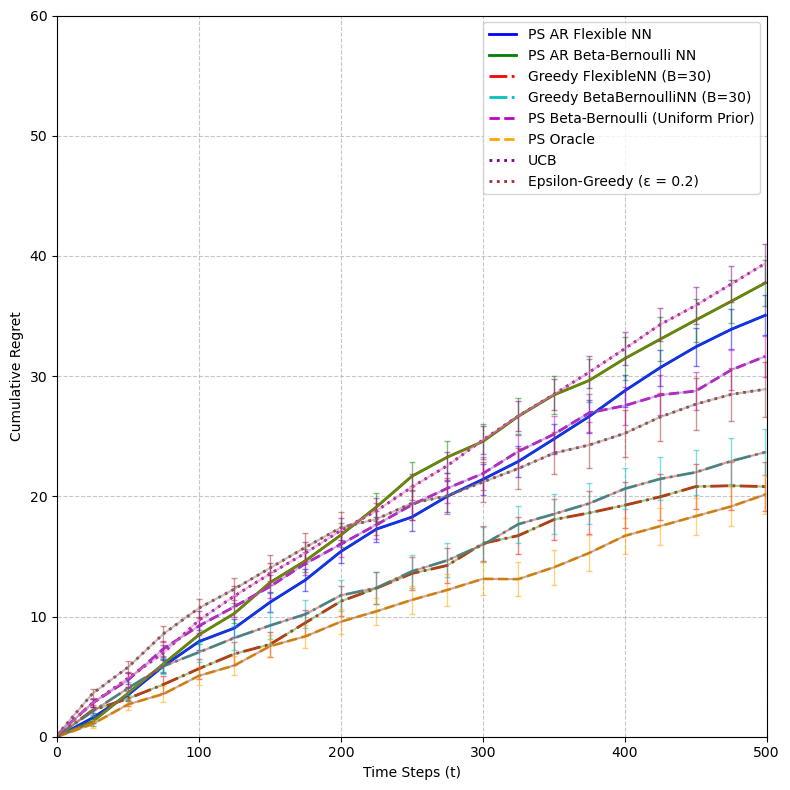

In [21]:
# Prepare inputs for the plotting function
all_regret_paths_list = [
    FlexibleNN_regret_paths_PS,
    BetaBernoulliNN_regret_paths_PS,
    FlexibleNN_regret_paths_Greedy_30,
    BetaBernoulliNN_regret_paths_Greedy_30,
    all_regret_paths_thompson_sampling,
    all_regret_paths_thompson_oracle,
    all_regret_paths_ucb,
    all_regret_paths_greedy,
]

names_list = [
    'PS AR Flexible NN',
    'PS AR Beta-Bernoulli NN',
    'Greedy FlexibleNN (B=30)',
    'Greedy BetaBernoulliNN (B=30)',
    'PS Beta-Bernoulli (Uniform Prior)',
    'PS Oracle',
    'UCB',
    f'Epsilon-Greedy (ε = 0.2)'
]

# Updated colors and line types for 6 algorithms
# colors_list = ['b', 'g', 'r', 'c', 'm', 'orange']  # Added 'm' (magenta) and 'orange'
# line_types_list = ['-', '--', '-.', ':', '-', '--']  # Added a solid line and a dashed line for new algorithms

# Update colors list to include two more colors for the new regret paths
colors_list = ['b', 'g', 'r', 'c', 'm', 'orange', 'purple', 'brown']  # Added 'purple' and 'brown' for the new lines

# Update line types list to include new line styles for the additional regret paths
line_types_list = ['-', '-', '-.', '-.', '--', '--', ':', ':']  # Added '-.' and ':' for the new lines

plot_mean_regret_with_error_bars(all_regret_paths_list, names_list, colors_list, line_types_list, interval=25)

In [185]:
num_runs = 100

epsilon_values = [0.0, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3]
all_regret_paths_epsilon_greedy = []

# Run Epsilon-Greedy with different values of epsilon
for eps in epsilon_values:
    print(f"Running Epsilon-Greedy with epsilon = {eps} for {num_runs} runs...")
    current_epsilon_regret_paths = []
    for _ in tqdm(range(num_runs)):
        _, regret_path = greedy(Z_new, T_new, optimal_z, eps=eps)
        current_epsilon_regret_paths.append(regret_path)
    all_regret_paths_epsilon_greedy.append(np.array(current_epsilon_regret_paths))

# Prepare inputs for the plotting function
names_list_epsilon = [f'Epsilon-Greedy (ε = {eps})' for eps in epsilon_values]
colors_list_epsilon = ['b', 'g', 'r', 'c', 'm', 'orange', 'purple']  # Added 'm' (magenta) and 'orange'
line_types_list_epsilon = ['-', '--', '-.', ':', '-', '--', '--']  # Added a solid line and a dashed line for new algorithms

Running Epsilon-Greedy with epsilon = 0.0 for 100 runs...


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 37.35it/s]


Running Epsilon-Greedy with epsilon = 0.03 for 100 runs...


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 38.52it/s]


Running Epsilon-Greedy with epsilon = 0.05 for 100 runs...


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 38.25it/s]


Running Epsilon-Greedy with epsilon = 0.1 for 100 runs...


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 38.46it/s]


Running Epsilon-Greedy with epsilon = 0.15 for 100 runs...


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 37.77it/s]


Running Epsilon-Greedy with epsilon = 0.2 for 100 runs...


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 38.12it/s]


Running Epsilon-Greedy with epsilon = 0.3 for 100 runs...


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 37.98it/s]


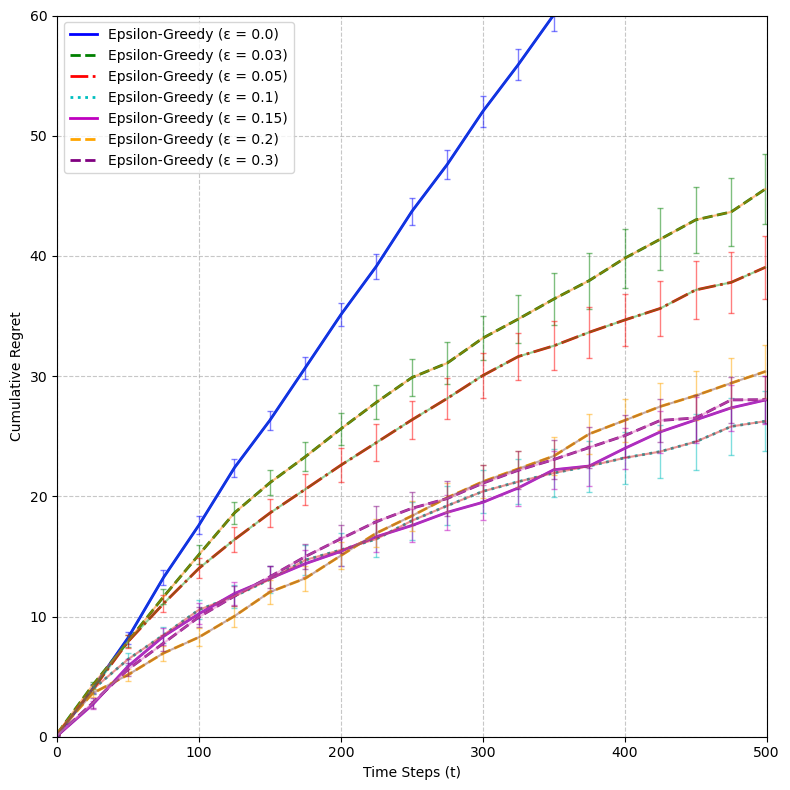

In [188]:
# Plot the results for epsilon-greedy experiments
plot_mean_regret_with_error_bars(all_regret_paths_epsilon_greedy, names_list_epsilon, 
                                 colors_list_epsilon, line_types_list_epsilon, interval=25)

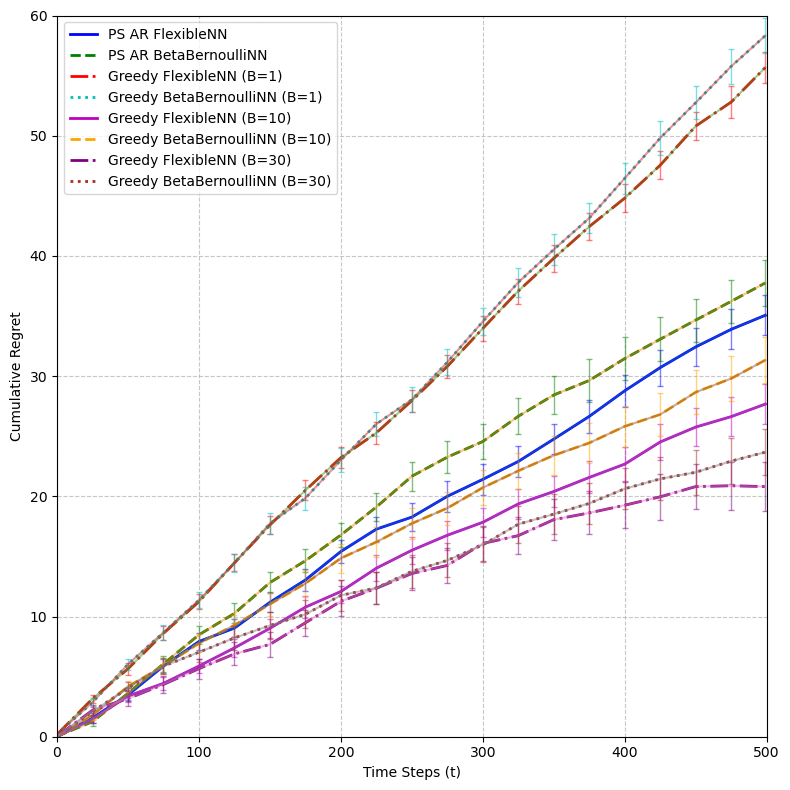

In [181]:
# Prepare inputs for the plotting function
all_regret_paths_list = [
    FlexibleNN_regret_paths_PS,
    BetaBernoulliNN_regret_paths_PS,
    FlexibleNN_regret_paths_Greedy_1,
    BetaBernoulliNN_regret_paths_Greedy_1,
    FlexibleNN_regret_paths_Greedy_10,
    BetaBernoulliNN_regret_paths_Greedy_10,
    FlexibleNN_regret_paths_Greedy_30,
    BetaBernoulliNN_regret_paths_Greedy_30,
]

# Update names list to include the new regret paths
names_list = [
    'PS AR FlexibleNN',
    'PS AR BetaBernoulliNN',
    'Greedy FlexibleNN (B=1)',
    'Greedy BetaBernoulliNN (B=1)',
    'Greedy FlexibleNN (B=10)',
    'Greedy BetaBernoulliNN (B=10)',
    'Greedy FlexibleNN (B=30)',
    'Greedy BetaBernoulliNN (B=30)',
]

# Update colors list to include two more colors for the new regret paths
colors_list = ['b', 'g', 'r', 'c', 'm', 'orange', 'purple', 'brown']  # Added 'purple' and 'brown' for the new lines

# Update line types list to include new line styles for the additional regret paths
line_types_list = ['-', '--', '-.', ':', '-', '--', '-.', ':']  # Added '-.' and ':' for the new lines

# Plot the results for the updated regret paths
plot_mean_regret_with_error_bars(all_regret_paths_list, names_list, colors_list, line_types_list, interval=25)